In [1]:
import fastf1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from matplotlib import pyplot as plt  
import datetime
import numpy as np
import joblib
fastf1.Cache.enable_cache('/Users/zanderbonnet/Desktop/GCU/Proj/f1_cache')

In [2]:
y23 = fastf1.get_event_schedule(2023, include_testing=False)['EventName'].values
y24 = fastf1.get_event_schedule(2024, include_testing=False)['EventName'].values
y25 = fastf1.get_event_schedule(2025, include_testing=False)
y25 = y25.iloc[np.where(
    pd.to_datetime('today', utc=True) > pd.to_datetime(y25['Session5DateUtc'], utc=True)
)]['EventName'].values



In [3]:
def format_data(race, qualifying,event_name, event_year):
    race.laps['LapTime'] = race.laps['LapTime'].dt.total_seconds()
    qualifying.laps['LapTime'] = qualifying.laps['LapTime'].dt.total_seconds()


    pitlap = race.laps['PitOutTime'].notna()
    pits = pitlap.rename('PitLap', inplace=True)

    data = race.laps[['Driver','DriverNumber','Team','LapTime','Compound','FreshTyre','TyreLife', 'LapNumber','TrackStatus']]
    starting_pos = race.results[['DriverNumber','GridPosition']]
    data['StartingPosition'] = data.merge(starting_pos, on = 'DriverNumber', how='left')['GridPosition']
    data['TrackStatus']=[list(x) for x in data['TrackStatus']]
    data = data.merge(pits, left_index=True, right_index=True)
    fastest_laps = qualifying.laps.groupby('Driver')['LapTime'].min().reset_index()
    data['EventYear'] = event_year
    data['EventName'] = event_name
    data = data.merge(fastest_laps, on='Driver', suffixes=('', '_Qualifying'))
    data = data.dropna()
    data = pd.DataFrame(data)
    return(data)
    

In [4]:

comp = pd.DataFrame()
events = dict(zip([2023,2024,2025], [y23, y24, y25]))
for year in events:
    for e in events[year]:
        race = fastf1.get_session(year, e, 'R')
        race.load(laps=True, telemetry=False, weather=False, messages=False)

        qualifying = fastf1.get_session(year, e, 'Q')
        qualifying.load(laps=True, telemetry=False, weather=False, messages=False)

        comp = pd.concat([comp, format_data(race, qualifying, e, year)], ignore_index=True)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data

In [5]:
comp

,Driver,DriverNumber,Team,LapTime,Compound,FreshTyre,TyreLife,LapNumber,TrackStatus,StartingPosition,PitLap,EventYear,EventName,LapTime_Qualifying
0,VER,1,Red Bull Racing,99.019,SOFT,False,4.0,1.0,"[1, 2]",1.0,False,2023,Bahrain Grand Prix,89.708
1,VER,1,Red Bull Racing,97.974,SOFT,False,5.0,2.0,"[1, 2]",1.0,False,2023,Bahrain Grand Prix,89.708
2,VER,1,Red Bull Racing,98.006,SOFT,False,6.0,3.0,[1],1.0,False,2023,Bahrain Grand Prix,89.708
3,VER,1,Red Bull Racing,97.976,SOFT,False,7.0,4.0,[1],1.0,False,2023,Bahrain Grand Prix,89.708
4,VER,1,Red Bull Racing,98.035,SOFT,False,8.0,5.0,[1],1.0,False,2023,Bahrain Grand Prix,89.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60842,BEA,87,Haas F1 Team,75.476,HARD,True,47.0,65.0,"[1, 2]",13.0,False,2025,Canadian Grand Prix,72.306
60843,BEA,87,Haas F1 Team,118.863,HARD,True,48.0,66.0,"[2, 4]",13.0,False,2025,Canadian Grand Prix,72.306
60844,BEA,87,Haas F1 Team,116.832,SOFT,True,1.0,67.0,[4],13.0,True,2025,Canadian Grand Prix,72.306
60845,BEA,87,Haas F1 Team,107.065,SOFT,False,2.0,68.0,[4],13.0,True,2025,Canadian Grand Prix,72.306


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

In [ ]:

catfeatures = ['Driver', 'Team', 'Compound', 'FreshTyre', 'PitLap', 'EventName', 'EventYear']
status = ['TrackStatus']
timefeat = ['LapTime_Qualifying']
numerical_features = ['TyreLife', 'LapNumber', 'LapTime', 'StartingPosition', 'DriverNumber']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), catfeatures),
        ('status', MultiHotEncoder(), status),
        ('num', StandardScaler(), timefeat)

    ],
    remainder='passthrough'  # Keep numerical features as is
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=1000, 
        learning_rate = .1,
        max_depth=5,
        random_state=100
        )
    )]
)


In [41]:
X = comp.drop(columns=['LapTime'])
y = comp['LapTime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['Driver', 'Team', 'Compound',
                                                   'FreshTyre', 'PitLap',
                                                   'EventName', 'EventYear']),
                                                 ('status', MultiHotEncoder(),
                                                  ['TrackStatus']),
                                                 ('num', StandardScaler(),
                                                  ['LapTime_Qualifying'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=Non...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [42]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse:.2f} seconds')

Root Mean Squared Error: 2.69 seconds


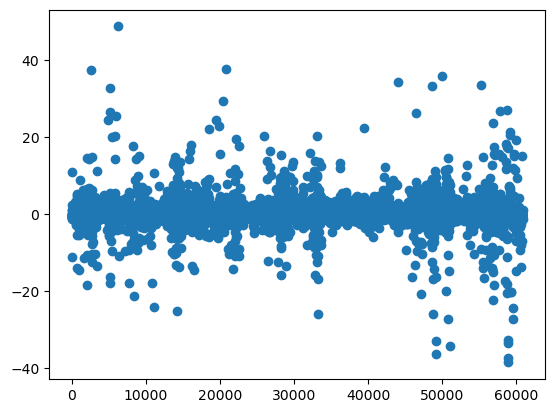

In [43]:
plt.scatter(y_test.index, y_test-y_pred)
plt.show()

In [44]:
y

0         99.019
1         97.974
2         98.006
3         97.976
4         98.035
          ...   
60842     75.476
60843    118.863
60844    116.832
60845    107.065
60846    122.225
Name: LapTime, Length: 60847, dtype: float64

In [45]:
for d in X['Driver'].unique():
    pred = model.predict(X[X['Driver'] == d])
    se = (y[X['Driver'] == d] - pred).mean()
    RMSE = root_mean_squared_error(pred, y[X['Driver'] == d].values)
    print(f'Driver {d} RMSE: {RMSE} || SE: {se}')


Driver VER RMSE: 1.5458034919940473 || SE: -0.022009563616501276
Driver GAS RMSE: 1.7999632486382695 || SE: -0.03719794493136204
Driver PER RMSE: 1.8975304251747043 || SE: -0.031029583620361817
Driver ALO RMSE: 1.8199111085508666 || SE: 0.0491887591158959
Driver LEC RMSE: 1.6675445131289264 || SE: -0.03304872430231149
Driver STR RMSE: 2.0641748487847256 || SE: 0.028584859373152888
Driver SAR RMSE: 1.949459355218131 || SE: 0.03431333267695385
Driver MAG RMSE: 1.718583049186789 || SE: -0.0035574607272106967
Driver DEV RMSE: 1.903604118921515 || SE: -0.06825190372604281
Driver TSU RMSE: 1.9708059503612345 || SE: 0.009016234823210996
Driver ALB RMSE: 1.814859822846345 || SE: -0.010387859404859005
Driver ZHO RMSE: 1.9504477907956252 || SE: -0.0015859712600707677
Driver HUL RMSE: 1.9292355436054798 || SE: -0.04708209751110662
Driver OCO RMSE: 2.0964424862527595 || SE: -0.08073550174054701
Driver NOR RMSE: 1.7742499011597808 || SE: -0.001968898373066705
Driver HAM RMSE: 1.9188262916419963 || 

2.679649120767137
1979     2.208221
1980     1.365612
1981    -3.403712
1982    -0.045213
1983     0.558170
           ...   
50322    1.679315
50323    2.938582
50324    2.354410
50325    1.523717
50326    1.815546
Name: LapTime, Length: 108, dtype: float64


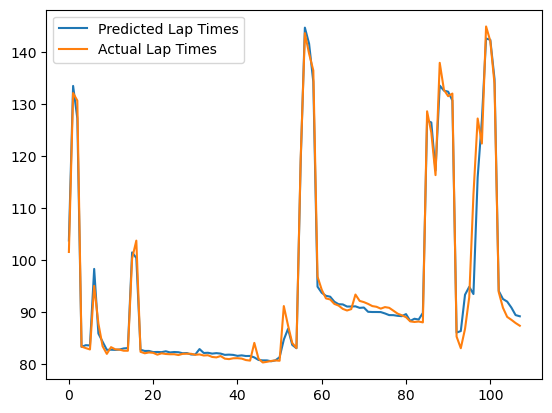

In [57]:
d ='VER'
race = 'Australian Grand Prix'
pred = model.predict(X[(X['Driver'] == d) & (X['EventName'] == race)])
print(root_mean_squared_error(pred, y[(X['Driver'] == d) & (X['EventName']==race)]))
print(pred - y[(X['Driver'] == d) & (X['EventName']==race)])
plt.plot(X[(X['Driver'] == d) & (X['EventName'] == race)].reset_index().index, pred, label='Predicted Lap Times')
plt.plot(X[(X['Driver'] == d) & (X['EventName'] == race)].reset_index().index, y[(X['Driver'] == d) & (X['EventName'] == race)], label='Actual Lap Times')
plt.legend()
plt.show()

In [58]:
y[(X['Driver'] == d) & (X['EventName']==race)].sum() - pred.sum()

np.float64(9.526234375000058)

In [ ]:
year = 2024
e = 'United States Grand Prix'
d = 'NOR'

verrace = fastf1.get_session(year, e, 'R')
verrace.load(laps=True, telemetry=False, weather=False, messages=False)
verqual = fastf1.get_session(year, e, 'Q')
verqual.load(laps=True, telemetry=False, weather=False, messages=False)
verdata = format_data(verrace, verqual, e, year)
verdata = verdata[verdata['Driver']==d]

verdata

events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.5.3]

,Driver,DriverNumber,Team,LapTime,Compound,FreshTyre,TyreLife,LapNumber,TrackStatus,StartingPosition,PitLap,EventYear,EventName,LapTime_Qualifying
722,NOR,4,McLaren,102.902,MEDIUM,True,1.0,1.0,"[1, 2]",1.0,False,2024,United States Grand Prix,92.33
723,NOR,4,McLaren,100.864,MEDIUM,True,2.0,2.0,[1],1.0,False,2024,United States Grand Prix,92.33
724,NOR,4,McLaren,124.410,MEDIUM,True,3.0,3.0,"[1, 2, 4]",1.0,False,2024,United States Grand Prix,92.33
727,NOR,4,McLaren,100.663,MEDIUM,True,6.0,6.0,[1],1.0,False,2024,United States Grand Prix,92.33
728,NOR,4,McLaren,100.469,MEDIUM,True,7.0,7.0,[1],1.0,False,2024,United States Grand Prix,92.33
729,NOR,4,McLaren,100.411,MEDIUM,True,8.0,8.0,[1],1.0,False,2024,United States Grand Prix,92.33
730,NOR,4,McLaren,100.196,MEDIUM,True,9.0,9.0,[1],1.0,False,2024,United States Grand Prix,92.33
731,NOR,4,McLaren,100.369,MEDIUM,True,10.0,10.0,"[1, 2]",1.0,False,2024,United States Grand Prix,92.33
732,NOR,4,McLaren,100.668,MEDIUM,True,11.0,11.0,[1],1.0,False,2024,United States Grand Prix,92.33
733,NOR,4,McLaren,100.652,MEDIUM,True,12.0,12.0,[1],1.0,False,2024,United States Grand Prix,92.33


In [14]:

verrace.results.columns


Index(['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName',
       'TeamColor', 'TeamId', 'FirstName', 'LastName', 'FullName',
       'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
       'GridPosition', 'Q1', 'Q2', 'Q3', 'Time', 'Status', 'Points'],
      dtype='object')

Root Mean Squared Error: 0.67 seconds


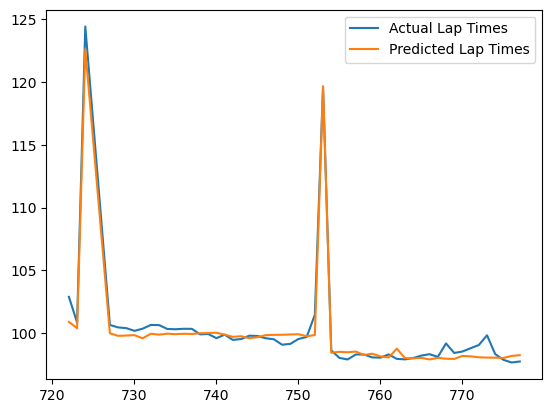

In [36]:
pred = model.predict(verdata.drop(columns=['LapTime']))

rmse = root_mean_squared_error(verdata['LapTime'], pred)
print(f'Root Mean Squared Error: {rmse:.2f} seconds')

plt.plot(verdata.index, verdata['LapTime'], label='Actual Lap Times')
plt.plot(verdata.index, pred, label='Predicted Lap Times')
plt.legend()
plt.show()

In [16]:
print(verdata['LapTime'].sum())
print(pred.sum())

5408.553999999999
5396.913


In [17]:
def convert_milliseconds(ms):
    hours = ms // (60 * 60)
    ms %= (60 * 60)
    minutes = ms // (60)
    ms %= (60)
    seconds = ms
    milliseconds = int(ms % 1 * 1000)
    return int(hours), int(minutes), int(seconds), milliseconds

# Example usage
time_in_ms = 5396.1777
hours, minutes, seconds, milliseconds = convert_milliseconds(time_in_ms)
print(f"{hours} hours, {minutes} minutes, {seconds} seconds, {milliseconds} milliseconds")

1 hours, 29 minutes, 56 seconds, 177 milliseconds


In [18]:
5396 // (60*60)

    

1